In [3]:
####################################################################################################################################################
## LIBRARIES:
import os
import cv2
import time
import enchant
import numpy as np
import TextDetection_and_Recognition_Functions as TDRF
####################################################################################################################################################
## MAIN: Capture and Live Predictions

# Get the working directory and paths to model weights to load:
work_path = os.getcwd()
EASTlite_path = os.path.join(work_path, "Models_Weights", "TFM_EAST_weights_ep200.h5")
Chars74k_path = os.path.join(work_path, "Models_Weights", "TFM_Chars74k_weights_ep37.h5")
EMNIST_path = os.path.join(work_path, "Models_Weights", "TFM_EMNIST_weights_ep67.h5")

# Load the webcam image and check if it's opened:
WebCam = cv2.VideoCapture(0)
if WebCam.isOpened():

    # If opened, display certain characteristic values:
    WC_width = int(WebCam.get(cv2.CAP_PROP_FRAME_WIDTH))
    WC_height = int(WebCam.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print("Webcam opened successfully. Its dimensions are: {} X {} (Width X Height).".format(WC_width, WC_height))

    # Load and generate models as a dictionary (absolute paths of weights), ready for prediction:
    print("Loading models for the task and Spanish corrector:")
    models_dict = TDRF.models_assembler({"EASTlite": EASTlite_path, "Chars74k": None, "EMNIST": EMNIST_path})
    corrector = enchant.Dict("es_ES")  # Spanish -> "es_ES" // English -> "en_IN"
    print("Ready to predict.")

    # Initialize the general program time and frame counter:
    gen_time = time.time()
    cont_img = 0

    # Launch the infinite loop that will handle predictions:
    while True:

        # Start local execution time and count one more frame:
        local_time = time.time()
        cont_img += 1

        # Obtain the webcam frame and check the success in reading it:
        success, img_BGR = WebCam.read()
        if not success:
            print("Could not read the webcam frame. Exiting.")
            print("FPS -> {} fps".format(round(cont_img / (time.time() - gen_time), 1)))
            break

        # Make a copy of the frame in RGB and make the prediction with EASTlite:
        img_RGB = img_BGR[:, :, ::-1].copy()  # BGR -> RGB
        boxes = TDRF.Text_Detection(models_dict["TextDetection"], img_RGB)

        # Check if there are bounding boxes from EASTlite to continue with the process:
        if len(boxes) != 0:

            # Extract and recognize the detected characters grouped in rows/columns:
            chr_boxes, message = TDRF.Text_Recognition_by_Characters(models_dict["TextRecognition"], img_RGB, boxes)

            # Display the bounding boxes from EASTlite passing through rows/columns:
            for row_BB in boxes:
                for BB in row_BB:
                    cv2.polylines(img_BGR, np.int32([BB]), True, (0, 0, 255), 2)

            # Display each bounding box of letters passing through rows/columns and the actual letters:
            for row_BB in chr_boxes:
                for colum_BB in row_BB:
                    for chars_BB in colum_BB:
                        cv2.polylines(img_BGR, np.int32([chars_BB]), True, (255, 0, 0), 2)

            # Write the located and corrected or uncorrected text at the end of the frame:
            msg_corrected = TDRF.message_corrector(message, corrector)
            cv2.putText(img_BGR, message.replace("\n", ""), (0, WC_height - 25), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255),
                        1, cv2.LINE_AA)
            cv2.putText(img_BGR, msg_corrected.replace("\n", ""), (0, WC_height - 5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,
                        (255, 0, 0), 1, cv2.LINE_AA)

        # Display the image along with the local elapsed time:
        cv2.putText(img_BGR, str(round(time.time() - local_time, 1)) + " sec", (WC_width - 85, 15),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 1, cv2.LINE_AA)
        cv2.imshow("Webcam Display", img_BGR)
        cv2.moveWindow("Webcam Display", 100, 100)

        # Check if the 'q' key is pressed to exit:
        if cv2.waitKey(1) & 0xFF == ord("q"):
            print("FPS -> {} fps".format(round(cont_img / (time.time() - gen_time), 1)))
            cv2.imwrite(os.path.join(work_path, "TDR_WebCam_Sample.png"), img_BGR)  # Save the image
            break

    # Outside the loop, close the webcam and windows:
    WebCam.release()
    cv2.destroyAllWindows()

else:
    print("The camera did not open properly.")
    WebCam.release()
    cv2.destroyAllWindows()

Webcam opened successfully. Its dimensions are: 640 X 480 (Width X Height).
Loading models for the task and Spanish corrector:
Ready to predict.
FPS -> 1.1 fps


Loading models for the task:

Proceeding to locate and recognize text in the following images:
	 - Determining the position of the text in the image and representing BBoxes.


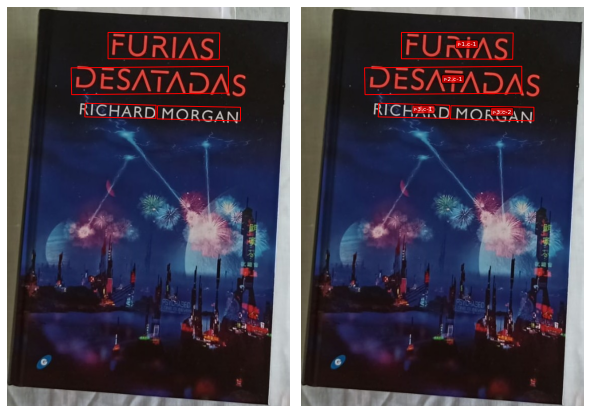


	- Searching for characters and recognizing them.


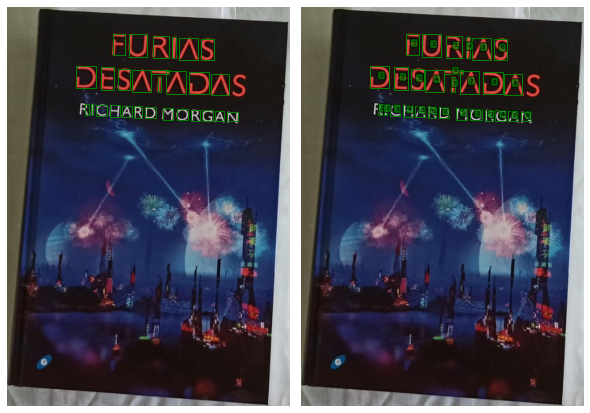


The message is:
furlas
desa17nda
tlchard m0rgan

The corrected message is:
furias 
desandada 
colchar margan 



In [2]:
####################################################################################################################################################
## LIBRARIES:
import os
import glob
import cv2
import enchant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
import TextDetection_and_Recognition_Functions as TDRF
####################################################################################################################################################
## VISUALIZATION FUNCTIONS:

# Visualization Function 1: Represents the image along with EASTlite text boxes
def EASTlite_visualization(im, anns, save_flag):
    
    # Create the figure with its axes and get the dimensions of the image:
    fig, axs = plt.subplots(1, 2, figsize=(8.3, 11.7/2))
    h, w, _ = im.shape  # Height X Width X Channel
    # NOTE: An A4 has [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). If I want the figure to occupy half
    # a sheet, I should divide the height by two (quarter).

    # Display the image in the first axis with its bounding boxes:
    axs[0].imshow(im.astype(np.uint8))
    for row_BBs in anns:  # Row of bounding boxes
        for BB in row_BBs:  # Columns/words of bounding boxes
            
            # Draw and add the selected bounding box:
            polygon = Polygon(BB, linewidth=1, edgecolor="r", facecolor="none")
            axs[0].add_patch(polygon)
            
    # Display the image in the second axis with its bounding boxes:
    axs[1].imshow(im.astype(np.uint8))
    for row_idx, row_BBs in enumerate(anns):  # Row of bounding boxes
        for colum_idx, BB in enumerate(row_BBs):  # Columns/words of bounding boxes
            
            # Draw and add the selected bounding box with its label in the CDG:
            polygon = Polygon(BB, linewidth=1, edgecolor="r", facecolor="none")
            axs[1].add_patch(polygon)
            cdg = [np.sum(BB[:, 0])/BB[:, 0].shape[0], np.sum(BB[:, 1])/BB[:, 1].shape[0]]
            axs[1].text(cdg[0], cdg[1], "r-{},c-{}".format(row_idx + 1, colum_idx + 1), color="w",
                        fontsize=6, bbox=dict(facecolor="red", alpha=0.7, boxstyle="round"))
            
    # Configure both axes and automatically adjust everything:
    axs[0].axis("off")
    axs[1].axis("off")
    plt.tight_layout()
    
    # Save the image as a high-resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("Image_Words.pdf")  # Create PDF
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close()  # Close the PDF
    return plt.gcf()

# Visualization Function 2: Represents the image along with character boxes
def characters_visualization(im, anns, save_flag):
    
    # Create the figure with its axes and get the dimensions of the image:
    fig, axs = plt.subplots(1, 2, figsize=(8.3, 11.7/2))
    h, w, _ = im.shape  # Height X Width X Channel
    # NOTE: An A4 has [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). If I want the figure to occupy half
    # a sheet, I should divide the height by two (quarter).

    # Display the image in the first axis with its bounding boxes:
    axs[0].imshow(im.astype(np.uint8))
    for row_BBs in anns:  # Row of bounding boxes
        for colum_BBs in row_BBs:  # Columns/words of bounding boxes
            for BB in colum_BBs:  # Characters within the word
            
                # Draw and add the selected bounding box:
                polygon = Polygon(BB, linewidth=1, edgecolor="g", facecolor="none")
                axs[0].add_patch(polygon)
            
    # Display the image in the second axis with its bounding boxes highlighted:
    axs[1].imshow(im.astype(np.uint8))
    for row_BBs in anns:  # Row of bounding boxes
        for colum_BBs in row_BBs:  # Columns/words of bounding boxes
            for idx, BB in enumerate(colum_BBs):  # Characters within the word
                
                # Draw and add the selected bounding box with its label in the CDG:
                polygon = Polygon(BB, linewidth=1, edgecolor="g", facecolor="none")
                axs[1].add_patch(polygon)
                cdg = [np.sum(BB[:, 0])/BB[:, 0].shape[0], np.sum(BB[:, 1])/BB[:, 1].shape[0]]
                axs[1].text(cdg[0], cdg[1], str(idx + 1), color="k",
                            fontsize=6, bbox=dict(facecolor="green", alpha=0.7, boxstyle="round"))
    
    # Configure both axes and automatically adjust everything:
    axs[0].axis("off")
    axs[1].axis("off")
    plt.tight_layout()
    
    # Save the image as a high-resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("Image_Characters.pdf")  # Create PDF
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close()  # Close the PDF
    return plt.gcf()

####################################################################################################################################################
## FUNCIONES:

# Function 1: Load the absolute paths of all sample images
def load_images_path(imgs_path):

    # Initialize the list that will store all absolute paths of images:
    all_img_files = []  # Images -> Generally ".jpg"

    # Iterate through each image extension and extract the complete list of images:
    for ext in ["jpeg", "jpg", "png"]:
        all_img_files.extend(glob.glob(os.path.join(imgs_path, "*.{}".format(ext))))

    # Finish the process by converting the list to an "array":
    return np.array(all_img_files)

# Function 2: Detect and recognize characters
def Text_Recognition_by_Characters(TR_model, img, TD_boxes):
    
    # Internal Function 1: Remove unwanted pixels in character detection and reorder
    def character_filter(all_chars_boxes):
        
        # Calculate the area of all possible character "bounding boxes" and determine the cutting area:
        boxes_area = (all_chars_boxes[:, 1, 0] - all_chars_boxes[:, 0, 0]) * (all_chars_boxes[:, 3, 1] - all_chars_boxes[:, 0, 1])
        area_lim = 0.2 * np.mean(boxes_area)
      
        # Divide all "bounding boxes" based on the area cut (characters) or not (isolated pixels):
        char_boxes = all_chars_boxes[np.where(boxes_area >= area_lim)[0], :, :]
        pix_boxes = all_chars_boxes[np.where(boxes_area < area_lim)[0], :, :]

        # Apply the algorithm if there are isolated pixels; otherwise, proceed directly to sorting:
        if len(pix_boxes) != 0:
            
            # Iterate through each pixel and check if it is the dot of "i" (case of isolated pixels):
            for pix_BB in pix_boxes:

                # Calculate the center of gravity (CDG) of the pixel "bounding box" and potential "i" dot:
                cdg_coord = [np.sum(pix_BB[:, 0]) / pix_BB[:, 0].shape[0], np.sum(pix_BB[:, 1]) / pix_BB[:, 1].shape[0]]

                # Iterate through all "bounding boxes" that pass the area cut:
                for idx, char_BB in enumerate(char_boxes):

                    # Determine if the potential "i" dot is in a suitable position:
                    if cdg_coord[0] >= np.min(char_BB[:, 0]) and cdg_coord[0] <= np.max(char_BB[:, 0]) and cdg_coord[1] < np.min(char_BB[:, 1]):

                        # Recalculate the coordinates of the "bounding box" to add the "i" dot (rectangular format):
                        char_boxes[idx, 0, :] = [np.minimum(char_BB[:, 0], pix_BB[:, 0]).min(), np.minimum(char_BB[:, 1], pix_BB[:, 1]).min()]
                        char_boxes[idx, 1, :] = [np.maximum(char_BB[:, 0], pix_BB[:, 0]).max(), np.minimum(char_BB[:, 1], pix_BB[:, 1]).min()]
                        char_boxes[idx, 2, :] = [np.maximum(char_BB[:, 0], pix_BB[:, 0]).max(), np.maximum(char_BB[:, 1], pix_BB[:, 1]).max()]
                        char_boxes[idx, 3, :] = [np.minimum(char_BB[:, 0], pix_BB[:, 0]).min(), np.maximum(char_BB[:, 1], pix_BB[:, 1]).max()]
                        break  # No need to search for another candidate
        
        # Calculate the CDGs and reorder the characters from left to right (with X):
        cdgs = np.column_stack((np.sum(char_boxes[:, :, 0], axis=1) / char_boxes[:, :, 0].shape[1],
                                np.sum(char_boxes[:, :, 1], axis=1) / char_boxes[:, :, 1].shape[1]))
        chars_boxes_filtered = char_boxes[np.argsort(cdgs[:, 0]), :, :]
        
        # Return the filtered and ordered "bounding boxes":
        return chars_boxes_filtered
    
    # Internal Function 2: Extract characters and classify them with the inserted model
    def character_recognition(TR_model, worl_crop, chars_boxes):
        
        # Initialize the array that will store all character cutouts:
        crops_tensor = np.zeros((chars_boxes.shape[0], TR_model["input_size"][0], TR_model["input_size"][1], 1), dtype=np.float32)

        # Iterate through each "bounding box" of characters to form the tensor:
        for idx, BB in enumerate(chars_boxes):
            
            # Get the dimensions of the rectangle covering the "bounding box" and crop it:
            xbb, ybb, wbb, hbb = cv2.boundingRect(BB.astype(np.int32))
            crop_BB = worl_crop[ybb:(ybb + hbb), xbb:(xbb + wbb)]
            
            # Calculate the ratio and new dimensions that respect the "aspect ratio":
            ratio = float(max(TR_model["input_size"])) / max((wbb, hbb))
            new_size = tuple([int(wbb * ratio), int(hbb * ratio)])  # Width x Height
            
            # Check that the new dimensions are suitable and resize the image:
            if new_size[0] > TR_model["input_size"][0] or new_size[1] > TR_model["input_size"][1]:
                ratio = float(min(TR_model["input_size"])) / min((wbb, hbb))
                new_size = tuple([int(wbb * ratio), int(hbb * ratio)])  # Width x Height
            crop_BB_rs = cv2.resize(crop_BB, new_size)  # Resize respecting the "aspect ratio"
            
            # Calculate the "padding" to add to meet the input dimensions of the network:
            delta_w = TR_model["input_size"][0] - new_size[0] if TR_model["input_size"][0] > new_size[0] else 0  # Padding in width
            delta_h = TR_model["input_size"][1] - new_size[1] if TR_model["input_size"][1] > new_size[1] else 0  # Padding in height
            top, bottom = delta_h // 2, delta_h - (delta_h // 2)
            left, right = delta_w // 2, delta_w - (delta_w // 2)
            crop_BB_rs = cv2.copyMakeBorder(crop_BB_rs, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
            
            # Add an extra dimension, normalize [0-1], and save the copy:
            crops_tensor[idx, :, :, :] = (np.expand_dims(crop_BB_rs, axis=-1) / 255).copy()
            
        # Pass the tensor to the recognition model and find the most probable characters:
        recog_hotshot = TR_model["model"].predict(crops_tensor, batch_size=crops_tensor.shape[0])
        max_idx = np.argmax(recog_hotshot, axis=1)  # Maximum of each sample
            
        # Return the detected word, joining all the characters:
        return TR_model["class"][max_idx].tobytes().decode("utf-8")
    
    # (START OF MAIN) Initialize the list that will store all "bounding boxes" of characters (per row):
    line_boxes = []
    
    # Initialize the message to be generated by character recognition:
    msg = ""
    
    # Iterate through each "bounding box" of each row:
    for row_BBs in TD_boxes:
        
        # Initialize the list that will store all "bounding boxes" of characters (per column/words):
        words_boxes = []
        
        # Iterate through each "bounding box" in the designated row:
        for BB in row_BBs:
            
            # Get the coordinates/dimensions of the box covering the "bounding box" and crop it:
            crop_x, crop_y, w, h = cv2.boundingRect(BB)
            img_crop = img[crop_y:(crop_y + h), crop_x:(crop_x + w)]
            
            # Skip to the next word if the crop is empty:
            if not np.any(img_crop):
                continue
            
            # Convert the crop to black and white and apply the "threshold" technique:
            crop_gray = cv2.cvtColor(img_crop, cv2.COLOR_RGB2GRAY)
            crop_retval, crop_thres = cv2.threshold(crop_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
            
            # Calculate the histogram and normalize it to the most used intensity level:
            if np.argmax(cv2.calcHist([crop_thres], [0], None, [256], [0, 256])) >= (255 / 2):
                crop_thres = cv2.bitwise_not(crop_thres)
            crop_thres = cv2.filter2D(crop_thres, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))  # Sharping
                
            # NOTE: It is desired that the characters to be detected have a structure similar to the training of the
            # "Chars74k" classifier, i.e., character in white and background in black. This will be marked by the
            # histogram; if the darkest intensity range, less than 255/2, is the most used, that means the background
            # is black, as desired. Otherwise, the levels need to be inverted.
            
            # Display the image:
            # cv2.imshow("Character", crop_thres.astype(np.uint8))
            # cv2.moveWindow("Character", 100, 100)
            # cv2.waitKey(0)
            # cv2.imwrite("Threshold.png", crop_thres.astype(np.uint8))
            # cv2.destroyAllWindows()
            
            # Find all contours (possible characters) and initialize the storage vector:
            crop_contours, crop_hierarchy = cv2.findContours(crop_thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            word_arrays = np.array([]).reshape((0, 4, 2))  # Format EASTlite

            # NOTE: The "bounding boxes" of the characters will store all of a single word/column, and
            # will be stored in EASTlite format: [x1, y1] for the upper-left corner, [x2, y2] for the upper-right
            # corner, [x3, y3] for the lower-right corner, and [x4, y4] for the lower-left corner. In a contour
            # detected by "cv2.boundingRect," the coordinates (X, Y) of the upper-left corner [x1, y1] are given in
            # EASTlite mode.
            
            # Iterate through each contour (possible character) detected:
            for crop_char in crop_contours:

                # Get the dimensions of the rectangle covering the detected contour:
                x, y, w, h = cv2.boundingRect(crop_char)

                # Calculate and store the coordinates (X, Y) of the characters in EASTlite mode:
                word_arrays = np.append(word_arrays, [np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])], axis=0)
                
            # Filter the detected characters and order them from left to right:
            word_arrays = character_filter(word_arrays.copy())
            
            # Classify each of the detected characters to generate the examined word:
            msg = msg + character_recognition(TR_model, crop_thres, word_arrays)  # Image with slight "blur"
            
            # Update the local coordinates to absolute (use of the upper-left corner [x1, y1] in EASTlite):
            word_arrays[:, :, 0] += crop_x
            word_arrays[:, :, 1] += crop_y

            # Store the absolute "bounding boxes" in the list of words:
            words_boxes.append(word_arrays)  # Filtered and ordered
            msg = msg + " "  # Space between words

        # Each group of words is stored in the list of rows:
        line_boxes.append(words_boxes)
        msg = msg[:-1] + "\n"  # Line break
        
    # Return the list of lists of filtered and ordered "bounding boxes" of characters, in addition to the message:
    return line_boxes, msg[:-1].replace("\x00", "").lower()  # Remove the code and convert to lowercase
####################################################################################################################################################
## MAIN: Images with detected text are displayed

# Get the working directory and generate the path for sample images:
work_path = os.getcwd()
img_sample_path = os.path.join(work_path, "Scene_Text_Sample")

# Load the absolute paths of the models to be used:
EASTlite_path = os.path.join(work_path, "Models_Weights", "TFM_EAST_weights_ep200.h5")
Chars74k_path = os.path.join(work_path, "Models_Weights", "TFM_Chars74k_weights_ep37.h5")
EMNIST_path = os.path.join(work_path, "Models_Weights", "TFM_EMNIST_weights_ep67.h5")

# Determine all the absolute paths of the sample images:
all_img_paths = load_images_path(img_sample_path)

# Load and generate the models as a dictionary, ready for prediction:
print("Loading models for the task:")
models_dict = TDRF.models_assembler({"EASTlite":EASTlite_path, "Chars74k":None, "EMNIST":EMNIST_path})

# Load the dictionary for the word corrector:
corrector = enchant.Dict("es_ES")  # Spanish->"es_ES" // English->"en_IN"

# Iterate through each image to extract and preprocess the text:
print("\nProceeding to locate and recognize text in the following images:")
for img_path in all_img_paths:
    
    # Load the image from the selected absolute path:
    img = cv2.imread(img_path)[:, :, ::-1]  # BGR -> RGB
    
    # Make a prediction to locate the text in the image:
    print("\t - Determining the position of the text in the image and representing BBoxes.")
    boxes = TDRF.Text_Detection(models_dict["TextDetection"], img)
    fig1 = EASTlite_visualization(img, boxes, False)
    plt.show()

    # Extract and recognize the detected characters grouped in rows/columns:
    print("\n\t- Searching for characters and recognizing them.")
    chr_boxes, message = Text_Recognition_by_Characters(models_dict["TextRecognition"], img, boxes)
    fig2 = characters_visualization(img, chr_boxes, False)
    plt.show()
    
    # Print the discovered message:
    print("\nThe message is:\n" + message)
    
    # Proceed to correct it:
    print("\nThe corrected message is:\n" + TDRF.message_corrector(message, corrector))